# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   


In [ ]:
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

%matplotlib inline

In [17]:
class Accuracy(torch.nn.Module):
    def __init__(self):
        super(Accuracy, self).__init__()

    def forward(self, outputs, targets):
        return torch.mean((outputs == targets).double())


def get_model_pretrained():
    model = torchvision.models.resnet18(pretrained=True)
    for param in list(model.parameters())[:-10]:
        param.requires_grad = False

    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, 200)

    return model

def conv(cin, cout, kernel_size=(3,3), padding=(1,1), stride=(1,1)):
    return nn.Sequential(
        nn.Conv2d(cin, cout, kernel_size, padding=padding, stride=stride),
        nn.ReLU(),
        nn.BatchNorm2d(cout),
        nn.MaxPool2d((2,2))
    )

def get_model(cin=3, cout=200):
    base = 64
    return torch.nn.Sequential(
        conv(cin, base), # 3, 64, 64 -> 64*32*32
        conv(base, base*2), # 64, 32, 32 -> 128*16*16
        # nn.Dropout(0.2),
#         conv(base*2, base*4), # 128, 16, 16 -> 256*8*8
#         conv(base*4, base*8), # 256, 8, 8 -> 512*4*4
        nn.Flatten(),
        # nn.Dropout(0.2, inplace=True),
#         nn.Linear(512*4*4, 1024),
#         nn.ReLU(inplace=True),
#         # nn.Dropout(0.2, inplace=True),
#         nn.Linear(1024, 512),
#         nn.ReLU(inplace=True),
        nn.Linear(128*16*16, 200),
        nn.LogSoftmax(dim=1)
    )

In [4]:
def train_one_epoch(model, dataloader, criterion, optimizer, metric, device):
    total_loss = 0
    total_acc = 0
    model.train(True)
    for i, (samples, targets) in enumerate(dataloader):
        samples = samples.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(samples)
        loss = criterion(outputs, targets)
        _, preds = torch.max(outputs, 1)
        total_acc += metric(preds, targets).item()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    i += 1
    total_loss /= i
    total_acc /= i

    return total_loss, total_acc


@torch.no_grad()
def eval_model(model, dataloader, criterion, metric, device):
    total_loss = 0
    total_acc = 0
    model.eval()

    for i, (samples, targets) in enumerate(dataloader):
        samples = samples.to(device)
        targets = targets.to(device)

        outputs = model(samples)
        total_loss += criterion(outputs, targets).item()
        _, preds = torch.max(outputs, 1)
        total_acc += metric(preds, targets).item()

    i += 1
    total_loss /= i
    total_acc /= i

    return total_loss, total_acc

In [5]:
def train_model(model, dataloaders, criterion, optimizer, metric, device, epochs=10):
    loss_hist = {'train': [], 'val': []}
    acc_hist = {'train': [], 'val': []}
    
    start = time()
    for epoch in range(epochs):
        loss, acc = train_one_epoch(model, dataloaders['train'], criterion, optimizer, metric, device)
        val_loss, val_acc = eval_model(model, dataloaders['val'], criterion, metric, device)
        print("Epoch [{}/{}] Time: {:.2f}s; Loss: {:.4f}; Accuracy: {:.4f}; ValLoss: {:.4f}; ValAccuracy: {:.4f}".format(
              epoch + 1, epochs, time() - start, loss, acc, val_loss, val_acc))
        loss_hist['train'].append(loss)
        loss_hist['val'].append(val_loss)
        
        acc_hist['train'].append(acc)
        acc_hist['val'].append(val_acc)
        
        start = time()

    return model, loss_hist, acc_hist

In [6]:
import pandas as pd
from dataset import ImgsDataset

def get_test_dataset(transform=None, 
                     base_img_dir='tiny-imagenet-200/val/images',
                     ids_file = 'tiny-imagenet-200/wnids.txt', 
                     annotation_file = 'tiny-imagenet-200/val/val_annotations.txt'):
    
    transform = transform or transforms.ToTensor()
    
    with open(ids_file, 'r') as f:
        ids = f.readlines()
    ids_map = {val: i for i, val in enumerate(sorted([val.strip() for val in ids]))}    
    
    df = pd.read_csv(annotation_file, sep='\t', header=None)    
    
    filenames, targets = [], []
    for i, (fn, tr) in df[[0, 1]].iterrows():
        filenames.append(fn)
        targets.append(ids_map[tr])
        
    return ImgsDataset(filenames, targets=targets, base_dir=base_img_dir, transform=transform)

In [23]:
def get_dataloaders(batch_size=200, val_size=0.2):
    print("Batch size %d" %batch_size)
    transform = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(15),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]), 

        'test': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    }
    
    dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform['train'])
    total_size = len(dataset)
    val_size = int(total_size * val_size if val_size < 1 else val_size)
    train_size = total_size - val_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    test_dataset = get_test_dataset(transform=transform['test'])
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
        'test': DataLoader(val_dataset, batch_size=batch_size, shuffle=False,  num_workers=4),
    }
    
    return dataloaders 


In [24]:
import matplotlib.pyplot as plt

def plot_hist(hist, title, ylabel):
    plt.title(title)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.plot(hist['train'], label='train')
    plt.plot(hist['val'], label='val')
    plt.legend()
    plt.show()

In [25]:
def run(epochs=15):
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    print("device %s" %device)
    model = get_model()
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    print(optimizer)
    metric = Accuracy()
    dataloaders = get_dataloaders()
    
    print('Run training')
    model, loss_hist, acc_hist = train_model(model, dataloaders, criterion, optimizer, metric, device, epochs=epochs)
    torch.save(model.state_dict(), 'models/model_simple_deep5.pth')
    loss_test, acc_test = eval_model(model, dataloaders['test'], criterion, metric, device)
    print("\nTEST Loss: {:.4f}; Accuracy: {:.4f}\n".format(loss_test, acc_test))
    
    plot_hist(loss_hist, "Loss History", 'CrossEntropyLoss')
    plot_hist(acc_hist, "Accuracy History", 'Accuracy')
    
    return model, loss_test, acc_test

device cuda:0
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Batch size 200
Run training
Epoch [1/15] Time: 50.81s; Loss: 10.5443; Accuracy: 0.0532; ValLoss: 6.2407; ValAccuracy: 0.0833
Epoch [2/15] Time: 49.74s; Loss: 5.0689; Accuracy: 0.1326; ValLoss: 4.4330; ValAccuracy: 0.1560
Epoch [3/15] Time: 51.27s; Loss: 3.7972; Accuracy: 0.2106; ValLoss: 3.8354; ValAccuracy: 0.2068
Epoch [4/15] Time: 49.82s; Loss: 3.3576; Accuracy: 0.2690; ValLoss: 3.6513; ValAccuracy: 0.2248
Epoch [5/15] Time: 50.63s; Loss: 3.1293; Accuracy: 0.3056; ValLoss: 3.5914; ValAccuracy: 0.2413
Epoch [6/15] Time: 50.93s; Loss: 2.9881; Accuracy: 0.3333; ValLoss: 3.5690; ValAccuracy: 0.2430
Epoch [7/15] Time: 51.70s; Loss: 2.8840; Accuracy: 0.3502; ValLoss: 3.5470; ValAccuracy: 0.2509
Epoch [8/15] Time: 51.45s; Loss: 2.7402; Accuracy: 0.3774; ValLoss: 3.6453; ValAccuracy: 0.2411
Epoch [9/15] Time: 51.85s; Loss: 2.6548; Accuracy: 0.3959; ValLoss: 3.

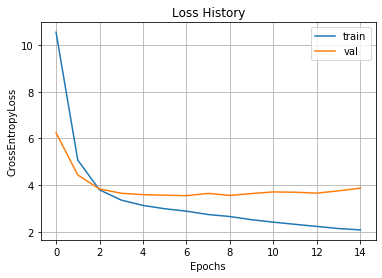

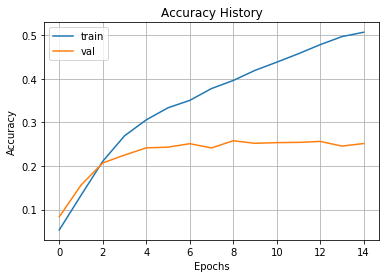

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (2): Flatten()
  (3): Linear(in_features=32768, out_features=200, bias=True)
  (4): LogSoftmax()
)

In [26]:
model, loss, acc = run(15)
model

When everything is done, please calculate accuracy on `tiny-imagenet-200/val`

In [ ]:
test_accuracy = .... # YOUR CODE

In [ ]:
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]

## Отчет

После долгой и нудной подготовки все данных для обучения и тестирования, наконец-то можно попробовать обучить модель

1. Первая попытка 
    - Прежде всего проведем проверку на уже обученной, модели resnet18. посредством transfer learning обучим ее на наших данных и посмотрим какие результатты можем получить
    - Не использовали аугментаций, только стандартная нормализация изображения
    - Получили на первых эпохах обучения хороший результат, файл `log1_pretrained_resnet18.txt`. 
    
    - Вывод: эти данные обучаемы, и на них можем добиться хорошего результата.
   
2. Вторая попытка. 
    - Сделаем простую модель с двумя сверточными блоками (conv + relu + max_pool) и одним линейным блоком с LogSoftMax активацией. 
    - Модель показывает не очень хороший результат
    - Быстро переобучается `Train_accuracy: 0.51, Test_accuracy_0.09`
    - Ниже соотвествующие грацики на тесте и валидации
    
3. Третья попытка. 
    - Добавим батч нормализацию в сверточные блоки (conv + relu + batch_norm + max_pool)
    - Модель Показывает лучший результат на старте
    - Но также быстро переобучается 
    - Итоговая точность `Train_accuracy: 0.99, Test_accuracy_0.17`
    - Ниже соотвествующие грацики на тесте и валидации
    
    
4. Четвертая попытка. 
    - Добавим data augmentation, поворот на 15 процентов и горизонтальное отображение 
    - Модель Показывает лучший результат и меньше переобучается
    - Итоговая точность `Train_accuracy: 0.50, Test_accuracy_0.25`
    - Ниже соотвествующие графики на тесте и валидации
    
